# Paramak to OpenMC (DAGMC) Workflow

This notebook walks through the full pipeline of:
1.  Creating a `paramak` reactor model.
2.  Converting the CAD model to a DAGMC `.h5m` file.
3.  Defining `openmc` materials, geometry, and settings.
4.  Plotting the DAGMC geometry in OpenMC.
5.  Running the OpenMC simulation.

## Step 0: Setup and Imports

In [17]:
import openmc
# import openmc.plotter
import paramak
from cad_to_dagmc import CadToDagmc
from pathlib import Path
from IPython.display import Image, display # For displaying plots
import numpy as np
import matplotlib.pyplot as plt
import neutronics_material_maker as nmm

# --- Step 0: Setup ---
# Set path for cross-sections.
openmc.config['cross_sections'] = Path.home() / 'nuclear_data' / 'cross_sections.xml'
print(f"Set openmc.config['cross_sections'] to {openmc.config['cross_sections']}")

# --- NEW: Define and create the output directory ---
output_dir = Path.cwd().parent / "outputs"
print(output_dir)
output_dir.mkdir(parents=True, exist_ok=True)
print(f"All outputs will be saved to: {output_dir}")

Set openmc.config['cross_sections'] to /home/vk/nuclear_data/cross_sections.xml
/home/vk/fusion-neutronics-modelling/outputs
All outputs will be saved to: /home/vk/fusion-neutronics-modelling/outputs


## Step 1: Create Paramak Model

A 180-degree sector model is created. The `radial_build_list` and `vertical_build_list` are defined to control the reactor's composition.

In [5]:
# --- 1. Global Component Dictionary ---
# Maps layer ID to ((R,G,B,A), "Nicer Name")
# This is now the single source of truth for colors and names.

COMPONENT_MAP = {
    'layer_1': ((0.1, 0.6, 0.1), "centre_column"),
    'layer_2': ((0.7, 0.7, 0.7), "magnet_shield"),
    'layer_3': ((0.9, 0.1, 0.1), "first_wall"),
    'layer_4': ((0.1, 0.1, 0.9), "breeder"),
    'layer_5': ((1.0, 0.7, 0.0), "rear_wall"),
    'plasma':  ((1.0, 0.2, 0.8, 0.6), "plasma"),
}

In [6]:
def basic_tokamak(paramak_colors, a = 100, t = 0.55):
    print("Creating Paramak model...")
    radial_build_list = [
        (paramak.LayerType.GAP, 10),
        (paramak.LayerType.SOLID, 30),
        (paramak.LayerType.SOLID, 50),
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.SOLID, (a / 100) * 70),  # breeder
        (paramak.LayerType.SOLID, 20),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.PLASMA, 300),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.SOLID, 20),
        (paramak.LayerType.SOLID, (a / 100) * 110),  # breeder
        (paramak.LayerType.SOLID, 10),
    ]

    vertical_build_list = [
        (paramak.LayerType.SOLID, 15),
        (paramak.LayerType.SOLID, (a / 100) * 80),  # breeder
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.GAP, 50),
        (paramak.LayerType.PLASMA, 700),
        (paramak.LayerType.GAP, 60),
        (paramak.LayerType.SOLID, 10),
        (paramak.LayerType.SOLID, (a / 100) * 40),  # breeder
        (paramak.LayerType.SOLID, 15),
    ]

    my_reactor = paramak.tokamak(
        radial_build=radial_build_list,
        vertical_build=vertical_build_list,
        triangularity=t,
        rotation_angle=180,
        colors=paramak_colors
    )

    reactor_material_tags = my_reactor.names()
    print(f"Reactor material tags found: {reactor_material_tags}")

    # --- USER REQUEST: Print attributes of my_reactor ---
    print(f"\nAttributes of my_reactor object:\n{dir(my_reactor)}\n")

    return (my_reactor, reactor_material_tags, radial_build_list)


paramak_colors = {
    name: details[0] for name, details in COMPONENT_MAP.items()
}

my_reactor, reactor_material_tags, radial_build_list = basic_tokamak(paramak_colors)

# Get the material tags from the reactor model.
reactor_material_tags = my_reactor.names()
print(f"Reactor material tags found: {reactor_material_tags}")

# --- USER REQUEST: Print attributes of my_reactor ---
print(f"\nAttributes of my_reactor object:\n{dir(my_reactor)}\n")

# This line will try to display the reactor object in Jupyter
my_reactor

Creating Paramak model...
Reactor material tags found: ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'plasma']

Attributes of my_reactor object:
['_solve_result', '_subshape_colors', '_subshape_layers', '_subshape_names', 'children', 'color', 'constraints', 'elongation', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'loc', 'major_radius', 'metadata', 'minor_radius', 'name', 'obj', 'objects', 'parent', 'plasma', 'triangularity']

Reactor material tags found: ['layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'plasma']

Attributes of my_reactor object:
['_solve_result', '_subshape_colors', '_subshape_layers', '_subshape_names', 'children', 'color', 'constraints', 'elongation', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'loc', 'major_radius', 'metadata', 'minor_radius', 'name', 'obj', 'objects', 'parent', 'plasma', 'triangularity']



## Step 2: Convert CAD to DAGMC

Uses `cad_to_dagmc` to convert the in-memory `paramak` object into a `.h5m` file for DAGMC.

In [7]:
def converter_code(my_reactor, reactor_material_tags):
    print("Converting CAD to DAGMC...")
    converter = CadToDagmc()

# Add the CadQuery assembly from the Paramak object
    converter.add_cadquery_object(
        my_reactor,
        material_tags=reactor_material_tags
    )

    h5m_filename = output_dir / "dagmc_reactor.h5m"

# Export the DAGMC .h5m file
    converter.export_dagmc_h5m_file(
        filename=str(h5m_filename),
        max_mesh_size=20.0,
        min_mesh_size=5.0
    )
    print(f"Successfully created {h5m_filename}")

    return (h5m_filename)



h5m_filename = converter_code(my_reactor, reactor_material_tags)


Converting CAD to DAGMC...
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Circle)
Info    : [  0%] Meshing curve 11 (Line)
Info    : [  0%] Meshing curve 16 (Circle)
Info    : [  0%] Meshing curve 15 (Line)
Info    : [  0%] Meshing curve 18 (Line)
Info    : [  0%] Meshing curve 19 (Line)
Info    : [  0%] Meshing curve 10 (Line)
Info    : [  0%] Meshing curve 5 (Circle)
Info    : [  0%] Meshing curve 20 (Line)
Info    : [  0%] Meshing curve 2 (Circle)
Info    : [  0%] Meshing curve 9 (Line)
Info    : [  0%] Meshing curve 14 (Line)
Info    : [  0%] Meshing curve 4 (Line)
Info    : [  0%] Meshing curve 3 (Line)
Info    : [  0%] Meshing curve 12 (Line)
Info    : [  0%] Meshing curve 8 (Circle)
Info    : [  0%] Meshing curve 17 (Line)
Info    : [  0%] Meshing curve 6 (Line)
Info    : [  0%] Meshing curve 7 (Line)
Info    : [  0%] Meshing curve 21 (Circle)
Info    : [  0%] Meshing curve 22 (Circle)
Info    : [  0%] Meshing curve 23 (BSpline)
Info    : [  0%] Meshing curve 25 (BSpl

## Step 3: Define OpenMC Materials

Creates an `openmc.Material` object for each material tag found in the `paramak` model. The material `name` must match the tag exactly.

In [11]:
def materials_library(reactor_material_tags):
    # --- RESET AUTO IDs ---
    # This resets the internal counters for Material, Cell, and Surface IDs
    # to prevent them from increasing every time the cell is re-run.
    openmc.reset_auto_ids()
    # --------------------

    print("Defining OpenMC materials...")
    materials_list = []

    eurofer_mat = nmm.Material.from_library('eurofer')

    for tag in reactor_material_tags:
        # Create a new material with the *exact* name as the tag
        mat = openmc.Material(name=tag)

    # In a real model, you'd add specific elements based on the tag
    # The 'paramak.tokamak' builder tags the plasma as 'plasma'
    # and other layers as 'radial_layer_1', 'vertical_layer_1' etc.
        if tag == 'plasma':
            mat.add_nuclide('H3', 1.0, 'ao')
            mat.add_nuclide('H2', 1.0, 'ao')  # Dummy plasma
            mat.set_density('g/cm3', 1.0e-6)
        elif tag == 'layer_4':
            mat.add_element(
                'Li',
                0.17,
                percent_type='ao',
                enrichment=60,
                enrichment_target='Li6',
                enrichment_type='ao')
            mat.add_element('Pb', 0.83, 'ao')
            mat.set_density('g/cm3', 11)
        # elif tag == 'layer_4':
            # mat.add_element('He', 1, 'ao')
            # mat.set_density('g/cm3', 0.1786)

        else:
            # Eurofer 97, can't get library import to work
            mat.add_element('Fe', 1, 'ao')
            mat.set_density('g/cm3', 7.8)

        materials_list.append(mat)

# Create the final Materials collection
    my_materials = openmc.Materials(materials_list)

    print(f"Created {len(my_materials)} materials")


    return (my_materials, materials_list)


my_materials, materials_list = materials_library(reactor_material_tags)
print(my_materials)

Defining OpenMC materials...
Created 6 materials
[Material
	ID             =	2
	Name           =	layer_1
	Temperature    =	None
	Density        =	7.8 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Fe54           =	0.05845      [ao]
	Fe56           =	0.91754      [ao]
	Fe57           =	0.02119      [ao]
	Fe58           =	0.00282      [ao]
, Material
	ID             =	3
	Name           =	layer_2
	Temperature    =	None
	Density        =	7.8 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Fe54           =	0.05845      [ao]
	Fe56           =	0.91754      [ao]
	Fe57           =	0.02119      [ao]
	Fe58           =	0.00282      [ao]
, Material
	ID             =	4
	Name           =	layer_3
	Temperature    =	None
	Density        =	7.8 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Fe54           =	0.05845      [ao]
	Fe56           =	0.91754      [ao

## Step 4: Define OpenMC Geometry

Creates the `DAGMCUniverse` and sets up the bounding box. Note the `reflective` boundary condition on the `y_min_surf` to model the 180-degree sector.

In [12]:
# Define a large, static bounding box (in cm)
max_boundary = 1200.0

def geometry_code(h5m_filename, max_boundary_input = 1200):
    print("Defining OpenMC geometry...")

    # Create the DAGMC Universe
    dag_univ = openmc.DAGMCUniverse(
        filename=str(h5m_filename),
        auto_geom_ids=True)



    # Set reflective boundary on the Y=0 plane for the 180-degree sector
    min_x = -max_boundary_input
    max_x = max_boundary_input
    min_y = 0.0  # <--- This is the cut plane
    max_y = max_boundary_input
    min_z = -max_boundary_input
    max_z = max_boundary_input

    # Define the bounding surfaces
    x_min_surf = openmc.XPlane(min_x, boundary_type='vacuum')
    x_max_surf = openmc.XPlane(max_x, boundary_type='vacuum')
    y_min_surf = openmc.YPlane(min_y, boundary_type='reflective')  # <-- REFLECTIVE
    y_max_surf = openmc.YPlane(max_y, boundary_type='vacuum')
    z_min_surf = openmc.ZPlane(min_z, boundary_type='vacuum')
    z_max_surf = openmc.ZPlane(max_z, boundary_type='vacuum')

    # Define the bounding cell
    bounding_cell = openmc.Cell(
        name='bounding_cell',
        region=+x_min_surf & -x_max_surf & +y_min_surf & -y_max_surf & +z_min_surf & -z_max_surf,
        fill=dag_univ
    )

    my_geometry = openmc.Geometry([bounding_cell])
    print("Geometry defined.")
    return my_geometry

my_geometry = geometry_code(h5m_filename, max_boundary)

Defining OpenMC geometry...
Geometry defined.


## Step 5: Define OpenMC Settings & Source

Calculates the approximate major radius to place the source. The source is nudged slightly off the Y=0 boundary to avoid particles starting on a reflective plane.

In [10]:
def settings_code(radial_build_list):
    print("Defining OpenMC settings...")
    # Calculate the approx. major radius from the radial_build
    radial_build_values = [item[1] for item in radial_build_list]
    plasma_index = radial_build_list.index((paramak.LayerType.PLASMA, 300))
    plasma_inner_radius = sum(radial_build_values[:plasma_index])
    plasma_thickness = radial_build_values[plasma_index]
    approx_major_radius = plasma_inner_radius + (plasma_thickness / 2.0)

    print(f"Placing source at approximate major radius: {approx_major_radius} cm")

    # Nudge source slightly off the y=0.0 reflective boundary
    source_location = (approx_major_radius, 0.01, 0.0)

    my_source = openmc.IndependentSource()
    my_source.space = openmc.stats.Point(source_location)
    my_source.angle = openmc.stats.Isotropic()
    my_source.energy = openmc.stats.Discrete([14.1e6], [1.0])  # 14.1 MeV neutrons

    my_settings = openmc.Settings()
    my_settings.batches = 10
    my_settings.particles = 500
    my_settings.run_mode = 'fixed source'
    my_settings.source = my_source


    tbr_cell_tally = openmc.Tally(name='tbr')
    tbr_cell_tally.scores = ['(n,Xt)']
    tbr_cell_tally.nuclides = ['Li6', 'Li7']

    mesh = openmc.RegularMesh()  # Need to check the qualities of this mesh
    mesh.dimension = [100, 100, 100]
    # x,y,z coordinates start at 0 as this is a sector model. May need to change.
    mesh.lower_left = [0, 0, -350]
    mesh.upper_right = [650, 650, 350]
    mesh_filter = openmc.MeshFilter(mesh)  # creating a mesh

    tbr_mesh_tally = openmc.Tally(name="tbr_on_mesh")
    tbr_mesh_tally.filters = [mesh_filter]
    tbr_mesh_tally.scores = ["(n,Xt)"]

    tallies = openmc.Tallies([tbr_cell_tally, tbr_mesh_tally])
    print("Settings defined.")
    return (my_settings, tallies)

my_settings, tallies = settings_code(radial_build_list)

Defining OpenMC settings...
Placing source at approximate major radius: 400.0 cm
Settings defined.


## Step 6: Plot Geometry

Defines and runs the OpenMC plotting. The resulting `.png` files are then displayed in the notebook.

Creating geometry plots...
{2: (25, 153, 25), 3: (178, 178, 178), 4: (229, 25, 25), 5: (25, 25, 229), 6: (255, 178, 0), 7: (255, 51, 204)}
Exporting XMLs to /home/vk/fusion-neutronics-modelling/outputs for plotting...
 Reading materials XML file...
 Reading geometry XML file...
Using the DOUBLE-DOWN interface to Embree.
Loading file /home/vk/fusion-neutronics-modelling/outputs/dagmc_reactor.h5m
Initializing the GeomQueryTool...
Using faceting tolerance: 5.13278e-315
Building acceleration data structures...
 Preparing distributed cell instances...
 Reading plot XML file...

 =======================>     PLOTTING SUMMARY     <========================

Plot ID: 1
Plot file: /home/vk/fusion-neutronics-modelling/outputs/reactor_plot_xy.png
Universe depth: -1
Plot Type: Slice
Origin: 0.0 0.0 0.0
Width: 2400.0 2400.0
Coloring: Materials
Basis: XY
Pixels: 1000 1000

Plot ID: 2
Plot file: /home/vk/fusion-neutronics-modelling/outputs/reactor_plot_xz.png
Universe depth: -1
Plot Type: Slice
Origin

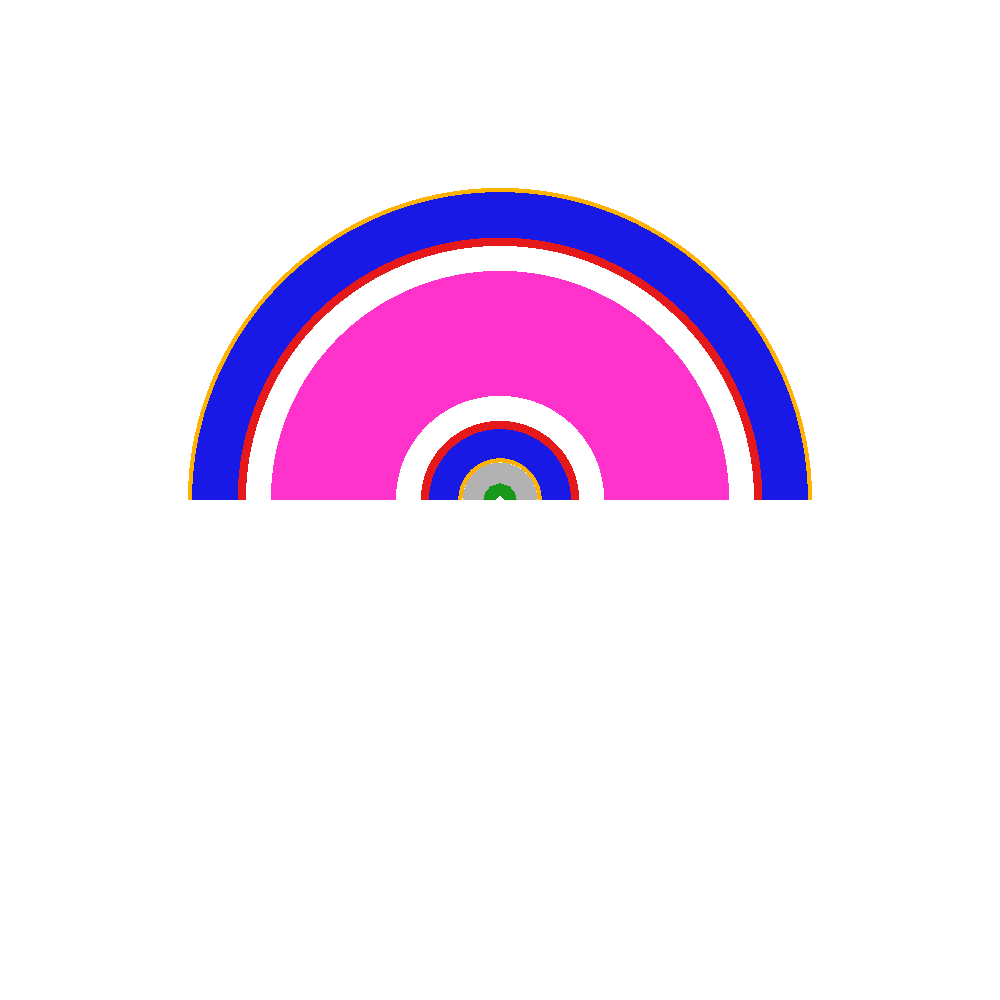

Displaying XZ (Cross-Section) View:


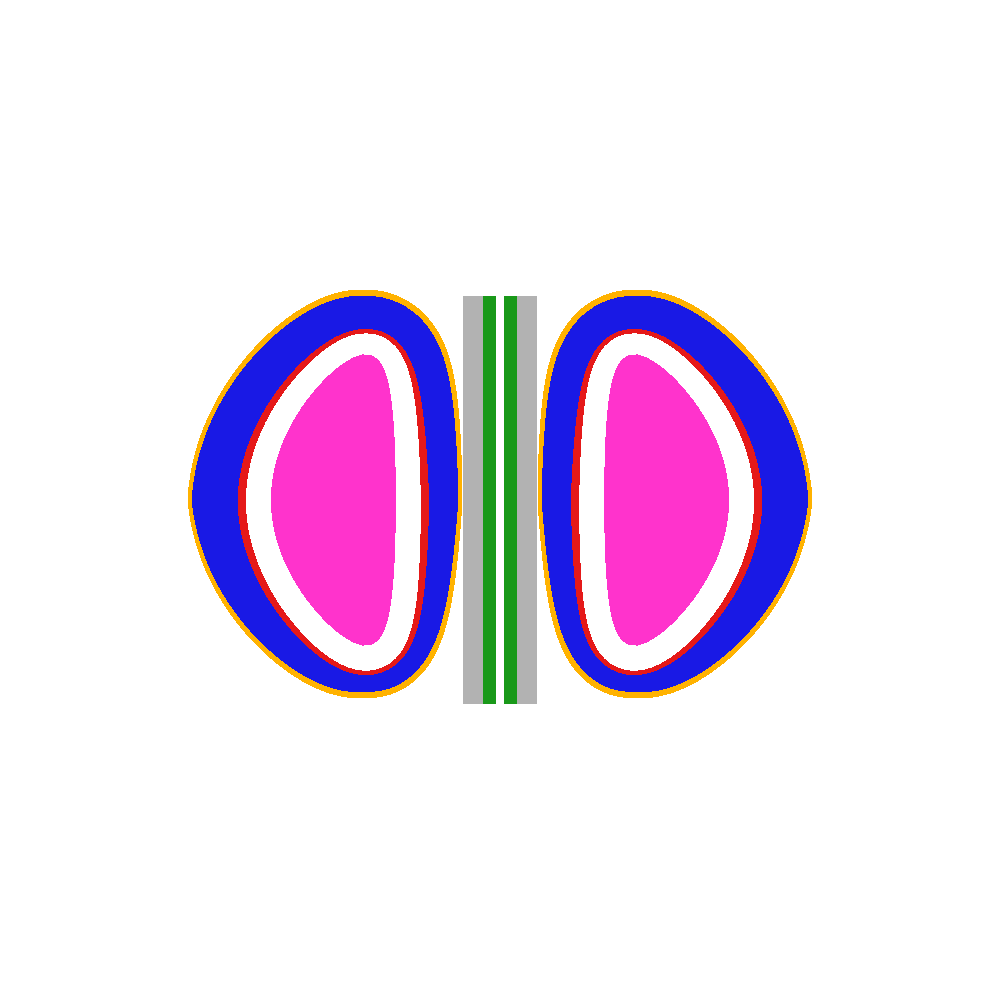

In [13]:
# --- RESET AUTO IDs ---
# This resets the internal counters for Material, Cell, and Surface IDs
# to prevent them from increasing every time the cell is re-run.
openmc.reset_auto_ids()
# --------------------

print("Creating geometry plots...")

color_map = {}

# Assuming materials_list is your list of openmc.Material objects
for mat in materials_list:
    mat_name = mat.name  # e.g., 'layer_1', 'plasma', 'radial_layer_gap_1'

    # Try to get color from our global map
    if mat_name in COMPONENT_MAP:

        # Get the (R, G, B, [A]) tuple, which is the first item
        color_tuple = COMPONENT_MAP[mat_name][0]

        # Convert 0.0-1.0 floats to 0-255 integers for OpenMC
        # Slicing [0:3] handles both RGB and RGBA tuples, ignoring Alpha
        openmc_color = tuple(int(c * 255) for c in color_tuple[0:3])

        # Add to our map: {openmc.Material.id: (R, G, B)}
        color_map[mat.id] = openmc_color  # <-- CHANGED: Use mat.id, not mat

    else:
        # NOT FOUND in map. This is likely a 'gap' layer or other.
        # Assign a default color.
        if 'gap' in mat_name:
            color_map[mat.id] = (240, 240, 240) # <-- CHANGED: Use mat.id
        else:
            color_map[mat.id] = (128, 128, 128) # <-- CHANGED: Use mat.id

print(color_map)

plot_xy = openmc.Plot()
plot_xy.filename = str(output_dir / 'reactor_plot_xy')
plot_xy.width = (max_boundary * 2, max_boundary * 2)
plot_xy.pixels = (1000, 1000)
plot_xy.basis = 'xy'
plot_xy.origin = (0, 0, 0)
plot_xy.color_by = 'material'
plot_xy.colors = color_map

plot_xz = openmc.Plot()
plot_xz.filename = str(output_dir / 'reactor_plot_xz')
plot_xz.width = (max_boundary * 2, max_boundary * 2)
plot_xz.pixels = (1000, 1000)
plot_xz.basis = 'xz'
plot_xz.origin = (0, 1, 0)
plot_xz.color_by = 'material'
plot_xz.colors = color_map

plots = openmc.Plots([plot_xy, plot_xz])

# --- NEW: Manually export the XMLs needed for plotting ---
print(f"Exporting XMLs to {output_dir} for plotting...")

# Define the path to the model.xml file
model_xml_path = output_dir / 'model.xml'

# Check if a stale model.xml exists from a previous simulation run
if model_xml_path.exists():
    print("Removing stale 'model.xml' to ensure plots.xml is used...")
    # Remove the file so openmc.plot_geometry() uses our new XMLs
    model_xml_path.unlink()
# --- END OF FIX ---

my_materials.export_to_xml(path=str(output_dir / 'materials.xml'))
my_geometry.export_to_xml(path=str(output_dir / 'geometry.xml'))
# We don't need settings.xml for plotting

# Now, export the plots.xml
plots.export_to_xml(path=str(output_dir / 'plots.xml'))

# Run the plotting
openmc.plot_geometry(cwd=str(output_dir))
print(f"Plots created in {output_dir}")

# --- Display plots in the notebook ---
print("Displaying XY (Top-Down) View:")
display(Image(str(output_dir / 'reactor_plot_xy.png')))

print("Displaying XZ (Cross-Section) View:")
display(Image(str(output_dir / 'reactor_plot_xz.png')))

## Step 7: Run Simulation

In [ ]:
# Basic Simulation

print("Running OpenMC simulation...")
my_model = openmc.Model(
    geometry=my_geometry,
    materials=my_materials,
    settings=my_settings
)
model_path = my_model.run(cwd=str(output_dir))
print(f"Simulation run complete. Results in {model_path}")

Running OpenMC simulation...
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
         

In [18]:
# Breeder Blanket Thickness Sweep

avg_thickenss = 75  # blanket thickness in centimeters, standard value of 75cm
triangularity = 0.55  # triangularity, standard value of 0.55


thickness_multipliers = np.arange(50, 151, 5)
thickness_values = thickness_multipliers * avg_thickenss
tbr_values = []
tbr_errors = []

for i in thickness_multipliers:
    reactor = basic_tokamak(i, triangularity)

    my_model = openmc.Model(
        geometry=geometry_code(converter_code(reactor[0], reactor[1])),
        materials=materials_library(reactor[1]),
        settings=settings_code(reactor[2])[0],
        tallies=settings_code(reactor[2])[1]
    )

    !rm * .h5

    statepoint_file = my_model.run()

    sp = openmc.StatePoint("statepoint.10.h5")

    tbr_cell_tally = sp.get_tally(name='tbr')

    tbr_values.append(tbr_cell_tally.mean.sum())
    tbr_errors.append(tbr_cell_tally.std_dev.sum())

Creating Paramak model...


AttributeError: 'numpy.int64' object has no attribute 'get'

In [ ]:
print(tbr_values)
print(tbr_errors)

plt.plot(thickness_values, tbr_values, 'k.')
plt.errorbar(thickness_values, tbr_values, tbr_errors, fmt='k.')

plt.title('TBR with Varying Blanket Thickness')
plt.xlabel('Average Blanket Thickness (cm)')
plt.ylabel('TBR')

plt.show()


Workflow complete.
